In [179]:
import math
import time
import torch
import numpy as np
import torch.nn as nn
from scipy import signal
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from numpy.random import choice, uniform
from scipy.interpolate import CubicSpline
from torch.utils.data import random_split
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal

In [180]:
class NoCommDataset(Dataset):
  def __init__(self, targets, hist_len):
    self.ori_targets = targets.T
    self.targets = targets.flatten('F')
    self.hist_len = hist_len

  def __len__(self):
    return self.targets.shape[0]

  def __getitem__(self, idx):
    # Simple trick to handle the first few samples
    if idx < self.hist_len:
      idx += self.hist_len - idx
    x = self.targets[idx-self.hist_len:idx]
    y = self.targets[idx]
    return x, y

  def in_out_dim(self):
    return self.hist_len, 1
  
  def get_data4prediction(self):
    pred_data = []
    for sample in self.ori_targets:
      pred_sample = []
      for i in range(len(sample)):
        if i >= self.hist_len:
          pred_sample.append(sample[i-self.hist_len:i])
      pred_data.append(pred_sample)
    return np.array(pred_data)


class CommDataset(Dataset):
  def __init__(self, sources, targets, hist_len):
    self.ori_targets = targets.T
    self.ori_sources = sources.T
    self.sources = sources.flatten('F')
    self.targets = targets.flatten('F')
    self.hist_len = hist_len

  def __len__(self):
    return self.targets.shape[0]

  def __getitem__(self, idx):
    # Simple trick to handle the first few samples
    if idx < self.hist_len:
      idx += self.hist_len - idx
    x = np.concatenate((self.targets[idx-self.hist_len:idx], self.sources[idx-self.hist_len:idx]))
    y = self.targets[idx]
    return x, y
  
  def in_out_dim(self):
    return 2*self.hist_len, 1
  
  def get_data4prediction(self):
    pred_data = []
    for sid in range(self.ori_targets.shape[0]):
      target = self.ori_targets[sid]
      source = self.ori_sources[sid]
      pred_sample = []
      for i in range(len(target)):
        if i >= self.hist_len:
          pred_sample.append(np.concatenate((target[i-self.hist_len:i], source[i-self.hist_len:i])))
      pred_data.append(pred_sample)
    return np.array(pred_data)


class LinearModel(torch.nn.Module):

  def __init__(self,input_dim=2,output_dim=2):
    super(LinearModel,self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim

    self.fc1 = torch.nn.Linear(input_dim,output_dim)
    self.log_sigma = torch.nn.Linear(input_dim,output_dim)
  
  def sample(self,x):
    dist = self.forward(x)
    return dist.sample()

  def get_stats(self,x):
    dist = self.forward(x)
    return dist.loc, dist.covariance_matrix

  def forward(self,x):
    mu = self.fc1(x)

    sigma = torch.exp(self.log_sigma(x))
    if self.output_dim != 1:
      cov = torch.diag_embed(sigma)
      m = MultivariateNormal(mu,cov)
    else:
      m = Normal(torch.squeeze(mu), torch.squeeze(sigma))
    return m

In [181]:
class ExampleTrainer:
    def __init__(self, dataset, model) -> None:
        self.dataset = dataset
        _, self.output_dim = dataset.in_out_dim()
        self.model = model

        self.train_set = None
        self.val_set = None
        self.train_loader = None
        self.val_loader = None

        self.epoch = 0

    def _prepare_data(self, train_val_ratio=0.8, batch_size=256) -> None:
        num_train = int(len(self.dataset)*train_val_ratio)
        torch.manual_seed(0) # Set torch's random seed so that random split of data is reproducible
        self.train_set, self.val_set = random_split(self.dataset, [num_train, len(self.dataset)-num_train])
        self.train_loader = DataLoader(self.train_set, shuffle=True, batch_size=batch_size)
        self.valid_loader = DataLoader(self.val_set, batch_size=batch_size)

        print('Number of training data:', len(self.train_set))
        print('Number of validation data:', len(self.val_set))
        sample_x, sample_y = next(iter(self.train_loader))
        print('x shape:', sample_x.shape, '\ny shape:', sample_y.shape)

    def _setup(self, max_epochs=8000, lr=1e-3, comm_type="Undefined") -> None:
        # Set hyperparameters
        self.max_epochs = max_epochs
        self.learning_rate = lr
        self.comm_type = comm_type

        self.min_avg_log_loss = 1e20
        self.min_avg_log_val_loss = 1e20

        self.min_avg_MSE_loss = 1e20
        self.min_avg_MSE_val_loss = 1e20

        # Create optimiser and MSE loss function
        self.optimiser = torch.optim.Adam(self.model.parameters(), weight_decay=1e-4, lr=self.learning_rate)
        self.MSE_loss_fn = torch.nn.MSELoss()

        # Initialise tensorboard writer
        self.timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        self.trainer_name = '{}'.format(self.comm_type)
        print("Trainer Name: ", self.trainer_name)

    def _train(self) -> None:
        self.start_time = time.time()
        for e in range(self.max_epochs):
            # Train
            self.model.train(True)
            avg_log_loss, avg_MSE_loss = self._train_one_epoch()
            if avg_log_loss < self.min_avg_log_loss:
                self.min_avg_log_loss = avg_log_loss
            if avg_MSE_loss < self.min_avg_MSE_loss:
                self.min_avg_MSE_loss = avg_MSE_loss

            # Validate
            self.model.train(False)
            avg_log_val_loss, avg_MSE_val_loss = self._validate_one_epoch()
            if avg_log_val_loss < self.min_avg_log_val_loss:
                self.min_avg_log_val_loss = avg_log_val_loss
            if avg_MSE_val_loss < self.min_avg_MSE_val_loss:
                self.min_avg_MSE_val_loss = avg_MSE_val_loss
                # Track best MSE performance, and save the model's state
                model_path = 'models/best_{}'.format(self.comm_type)
                torch.save(self.model.state_dict(), model_path)
            
            # Print loss
            elapsed = time.time() - self.start_time
            elapsed = "%02d:%02d:%02d" % (elapsed//3600, elapsed//60%60, elapsed%60)
            print('EPOCH {}: MSE LOSS train {} valid {} TIME Elapsed: {}'.format(self.epoch, avg_MSE_loss, avg_MSE_val_loss, elapsed))

            # Save checkpoint every 10 epochs
            if e % 10 == 9:
                checkpoint = {'epoch': self.epoch, 'state_dict': self.model.state_dict(), 'optimizer': self.optimiser.state_dict()}
                self._save_ckp(checkpoint, "ckps/" + self.trainer_name + ".pt")

    def _loss_fn(self, y_pred, y_true):
        if self.output_dim != 1:
          y_pred.loc = torch.squeeze(y_pred.loc)
          y_pred.covariance_matrix = torch.squeeze(y_pred.covariance_matrix)
          return torch.mean(-MultivariateNormal(y_pred.loc, y_pred.covariance_matrix).log_prob(y_true))
        else:
          y_pred.loc = torch.squeeze(y_pred.loc)
          y_pred.scale = torch.squeeze(y_pred.scale)
          return torch.mean(-Normal(y_pred.loc, y_pred.scale).log_prob(y_true))

    def _train_one_epoch(self):
        running_loss = 0.
        last_loss = 0.

        running_MSE_loss = 0.
        last_MSE_loss = 0.
        
        for inputs, labels in self.train_loader:
            inputs = torch.unsqueeze(inputs, dim=1).float()
            labels = torch.squeeze(labels.float())

            self.optimiser.zero_grad()
            outputs = self.model(inputs)

            loss = self._loss_fn(outputs, labels)
            MSE_loss = self.MSE_loss_fn(torch.squeeze(outputs.loc), labels)
            loss.backward()

            self.optimiser.step()

            running_loss += loss.item()
            running_MSE_loss += MSE_loss.item()

        last_loss = running_loss / len(self.train_loader) # loss per batch
        last_MSE_loss = running_MSE_loss / len(self.train_loader)
        self.epoch += 1

        return last_loss, last_MSE_loss
    
    def _validate_one_epoch(self):
        running_log_val_loss = 0.0
        running_MSE_val_loss = 0.0

        with torch.no_grad():
            for i, vdata in enumerate(self.valid_loader):
                vinputs, vlabels = vdata
                vinputs = torch.unsqueeze(vinputs, dim=1).float()
                vlabels = torch.squeeze(vlabels.float())
                voutputs = self.model(vinputs)
                vloss = self._loss_fn(voutputs, vlabels)
                visual_vloss = self.MSE_loss_fn(torch.squeeze(voutputs.loc), vlabels)
                running_log_val_loss += vloss
                running_MSE_val_loss += visual_vloss
            avg_log_val_loss = running_log_val_loss / (i + 1)
            avg_MSE_val_loss = running_MSE_val_loss / (i + 1)
        
        return avg_log_val_loss, avg_MSE_val_loss
    
    def _save_ckp(self, state, checkpoint_dir):
        torch.save(state, checkpoint_dir)

    def _predict(self):
        pred_X = self.dataset.get_data4prediction()
        entropy_all = []
        pred_y_all = []
        for pred_x in pred_X:
            pred_x = torch.from_numpy(pred_x).float()
            pred_y = self.model(pred_x)
            pred_y.loc = torch.squeeze(pred_y.loc)
            if self.output_dim != 1:
                pred_y.covariance_matrix = torch.squeeze(pred_y.covariance_matrix)
            else:
                pred_y.scale = torch.squeeze(pred_y.scale)
            pred_y_all.append(pred_y.loc.detach().numpy())

            entropy = []
            for i in range(pred_y.loc.shape[0]):
                if self.output_dim != 1:
                    multinorm = MultivariateNormal(loc=pred_y.loc[i], covariance_matrix=pred_y.covariance_matrix[i])
                else:
                    multinorm = Normal(loc=pred_y.loc[i], scale=pred_y.scale[i])
                entropy.append(multinorm.entropy().detach().numpy())
            entropy = np.stack(entropy)
            entropy_all.append(entropy)

        prediction = np.array(pred_y_all)
        entropy_data = np.array(entropy_all)
        return prediction, entropy_data

In [182]:
def generate_single_sample(cue_start_idxs, cue_mag, cue_len, offset, noise_level, length=1000):
    # Generate base signal
    sample = np.zeros((length,))
    # Generate cue
    mu = 0
    variance = 1
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, cue_len)
    c = stats.norm.pdf(x, mu, sigma)
    c = cue_mag*(c/np.max(c))
    # Add cue onto the base signal
    for csi in cue_start_idxs:
        sample[csi:csi+cue_len] = sample[csi:csi+cue_len] + c
    # Add offset and noise
    return sample + offset + np.random.normal(scale=noise_level, size=(sample.shape))

def generate_samples(num, source_cue_mean_idxs, target_cue_mean_idxs):
    # Generate sources
    sources = []
    for _ in range(num):
        cue_start_idxs = []
        for source_cmi in source_cue_mean_idxs:
            cue_start_idxs.append(choice(np.arange(source_cmi-10, source_cmi+10)))
        cue_mag = uniform(0.4, 0.6)
        cue_len = choice(np.arange(250, 350))
        offset = uniform(0.98, 1.02)
        sources.append(generate_single_sample(cue_start_idxs, cue_mag, cue_len, offset, 0.005))
    sources = np.array(sources).T
    # Generate targets
    targets = []
    for _ in range(num):
        cue_start_idxs = []
        for target_cmi in target_cue_mean_idxs:
            cue_start_idxs.append(choice(np.arange(target_cmi-10, target_cmi+10)))
        cue_mag = uniform(0.4, 0.6)
        cue_len = choice(np.arange(250, 350))
        offset = uniform(0.98, 1.02)
        targets.append(generate_single_sample(cue_start_idxs, cue_mag, cue_len, offset, 0.005))
    targets = np.array(targets).T

    return sources, targets

(1000, 20)


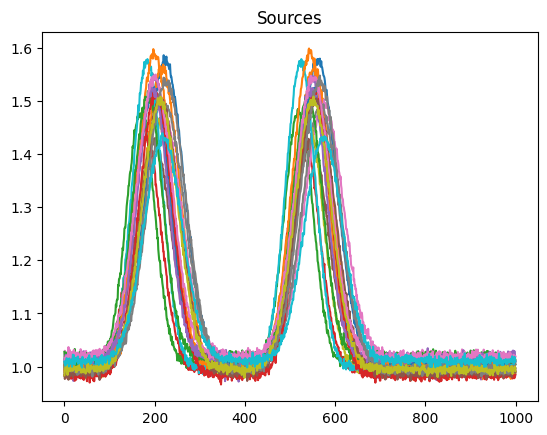

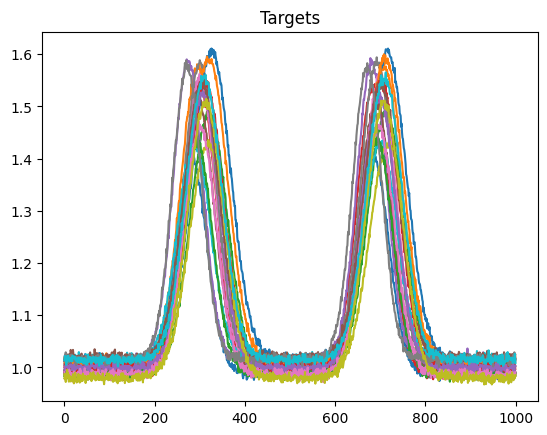

In [183]:
# Generate some samples
sources, targets = generate_samples(20, source_cue_mean_idxs=[50, 400], target_cue_mean_idxs=[150, 550])
print(sources.shape)

plt.figure()
plt.plot(sources)
plt.title('Sources')
plt.figure()
plt.title('Targets')
plt.plot(targets)
plt.show()

In [184]:
# Create datasets
hist_len = 10
nocomm_dataset = NoCommDataset(targets=targets, hist_len=hist_len)
comm_dataset = CommDataset(sources=sources, targets=targets, hist_len=hist_len)
print("NoCommDataset (input, output) dimension: {}".format(nocomm_dataset.in_out_dim()))
print("CommDataset (input, output) dimension: {}".format(comm_dataset.in_out_dim()))

NoCommDataset (input, output) dimension: (10, 1)
CommDataset (input, output) dimension: (20, 1)


In [185]:
# Create models
input_dim, output_dim = nocomm_dataset.in_out_dim()
nocomm_model = LinearModel(input_dim=input_dim,output_dim=output_dim)
input_dim, output_dim = comm_dataset.in_out_dim()
comm_model = LinearModel(input_dim=input_dim,output_dim=output_dim)

In [186]:
# Initialise trainers
nocomm_trainer = ExampleTrainer(nocomm_dataset, nocomm_model)
comm_trainer = ExampleTrainer(comm_dataset, comm_model)

In [187]:
# Train model assuming no communication
nocomm_trainer._prepare_data(train_val_ratio=0.8, batch_size=256)
nocomm_trainer._setup(max_epochs=30, lr=5e-4, comm_type="NoComm")
nocomm_trainer._train()
nocomm_prediction, nocomm_entropy = nocomm_trainer._predict()

Number of training data: 16000
Number of validation data: 4000
x shape: torch.Size([256, 10]) 
y shape: torch.Size([256])
Trainer Name:  NoComm
EPOCH 1: MSE LOSS train 0.17128639561789377 valid 0.04391494020819664 TIME Elapsed: 00:00:00
EPOCH 2: MSE LOSS train 0.010800111336663129 valid 0.001236580079421401 TIME Elapsed: 00:00:00
EPOCH 3: MSE LOSS train 0.001251766842509073 valid 0.0012923707254230976 TIME Elapsed: 00:00:00
EPOCH 4: MSE LOSS train 0.0012941181914703477 valid 0.0013188400771468878 TIME Elapsed: 00:00:00
EPOCH 5: MSE LOSS train 0.0012611612522353728 valid 0.0013686910970136523 TIME Elapsed: 00:00:00
EPOCH 6: MSE LOSS train 0.001074212047988401 valid 0.0008718398166820407 TIME Elapsed: 00:00:00
EPOCH 7: MSE LOSS train 0.0007771912265554188 valid 0.0005807201960124075 TIME Elapsed: 00:00:01
EPOCH 8: MSE LOSS train 0.0005360076509763501 valid 0.0004992525209672749 TIME Elapsed: 00:00:01
EPOCH 9: MSE LOSS train 0.000404985089849178 valid 0.0004675798409152776 TIME Elapsed: 0

In [188]:
# Train model assuming communication
comm_trainer._prepare_data(train_val_ratio=0.8, batch_size=256)
comm_trainer._setup(max_epochs=30, lr=5e-4, comm_type="Comm")
comm_trainer._train()
comm_prediction, comm_entropy = comm_trainer._predict()

Number of training data: 16000
Number of validation data: 4000
x shape: torch.Size([256, 20]) 
y shape: torch.Size([256])
Trainer Name:  Comm
EPOCH 1: MSE LOSS train 0.21183379715870296 valid 0.013487424701452255 TIME Elapsed: 00:00:00
EPOCH 2: MSE LOSS train 0.010590537081635187 valid 0.0070977844297885895 TIME Elapsed: 00:00:00
EPOCH 3: MSE LOSS train 0.003746598515482176 valid 0.0011591314105316997 TIME Elapsed: 00:00:00
EPOCH 4: MSE LOSS train 0.0008280294298726533 valid 0.0008076055673882365 TIME Elapsed: 00:00:00
EPOCH 5: MSE LOSS train 0.0006940623991087907 valid 0.0008028571610338986 TIME Elapsed: 00:00:01
EPOCH 6: MSE LOSS train 0.0006105615711209201 valid 0.0005140589200891554 TIME Elapsed: 00:00:01
EPOCH 7: MSE LOSS train 0.0005547282154790111 valid 0.0005554259405471385 TIME Elapsed: 00:00:01
EPOCH 8: MSE LOSS train 0.0005068660830147564 valid 0.00046888599172234535 TIME Elapsed: 00:00:01
EPOCH 9: MSE LOSS train 0.0004693305855321269 valid 0.000468571437522769 TIME Elapsed:

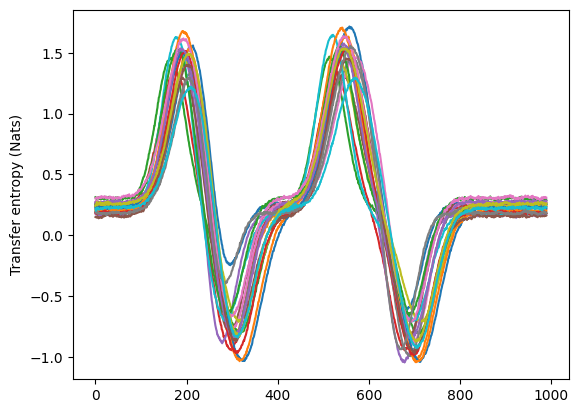

In [189]:
# Compute transfer entropy
TE_all = nocomm_entropy - comm_entropy
plt.plot(TE_all.T)
plt.ylabel('Transfer entropy (Nats)')
plt.show()

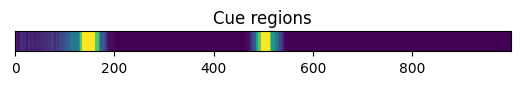

In [190]:
def double_exponential_mean_smoothing(x_t, m_t_1, b_t_1, alpha, beta):
    m_t = alpha*x_t + (1-alpha)*(m_t_1 + b_t_1)
    b_t = beta*(m_t - m_t_1) + (1-beta)*b_t_1
    return m_t, b_t

def double_exponential_std_smoothing(x_t, s_t_1, m_t_1, b_t_1, alpha):
    return (1-alpha)*(s_t_1 + alpha*(x_t-m_t_1-b_t_1)*(x_t-m_t_1))

def get_cue_regions(TE, alpha, beta, sigma):
    mean_alpha = alpha
    std_alpha = alpha
    moving_mean = [TE[0]]
    moving_std = [0]
    moving_trend = [TE[1]-TE[0]]

    for i in range(1,len(TE)):
        m_t, b_t = double_exponential_mean_smoothing(TE[i], moving_mean[-1], moving_trend[-1], mean_alpha, beta)
        moving_mean.append(m_t)
        moving_trend.append(b_t)
        s_t = double_exponential_std_smoothing(TE[i], moving_std[-1], moving_mean[-2], moving_trend[-2], std_alpha)
        moving_std.append(s_t)

    moving_mean = np.array(moving_mean)
    moving_std = np.array(moving_std)

    threshold = moving_mean + sigma*moving_std
    threshold = np.where(threshold < 0, 0, threshold)
    cue_regions = np.where(TE > threshold, 1, 0)

    return cue_regions

def double_exponential_smoothing_cue_detection(TE):
    # Process data
    processed_all_TE = []
    sos = signal.butter(1, 1, 'hp', fs=1000, output='sos')
    for te in TE:
        x = np.linspace(0, len(te), 1000)
        cs = CubicSpline(np.arange(len(te)), te)
        processed_all_TE.append(signal.sosfilt(sos, cs(x)))

    # Find cue regions
    cue_regions_all = []
    for te in processed_all_TE:
        cue_regions_all.append(get_cue_regions(te, alpha=0.05, beta=0.01, sigma=3))
    
    a = 0.3
    cue_regions_count = np.exp(a*np.sum(cue_regions_all, axis=0))
    return cue_regions_count


# Compute cue regions
cue_regions_count = double_exponential_smoothing_cue_detection(TE_all)
plt.imshow(cue_regions_count.reshape(1,-1), aspect=40, interpolation='none')
plt.yticks([])
plt.title('Cue regions')
plt.show()